In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({
    'image.origin' : 'lower',
    'image.interpolation' : 'nearest',
    'figure.dpi' : 100,
})
from matplotlib.colors import LogNorm, SymLogNorm, Normalize

import numpy as np
from magpyx.fdpr2 import console, tools
from magpyx.instrument import set_camera_roi

from purepyindi import INDIClient
from purepyindi import SwitchState as SwitchState0

from astropy.io import fits
from poppy import zernike
import cupy as cp

from scipy.ndimage import binary_closing, binary_erosion

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
import scoobi.imshows as imshows
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.utils as utils

import lina


INFO:numexpr.utils:NumExpr defaulting to 12 threads.
/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


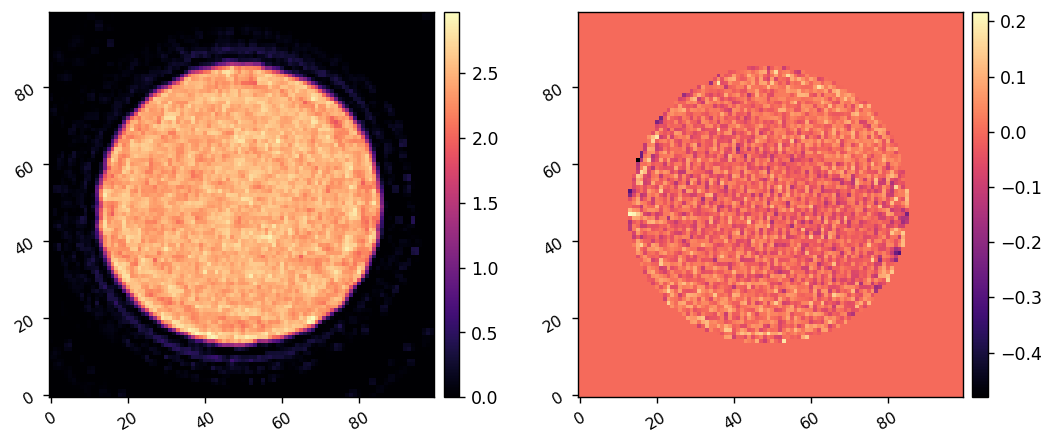

In [3]:
fname = 'data/20250121_fdpr2_prefpm_ref.pkl'

fdpr2_data = utils.load_pickle(fname)
Imeas = fdpr2_data['Imeas']
ref_amp = fdpr2_data['AMP']
ref_phs = fdpr2_data['PHS']
imshow2(ref_amp, ref_phs, npix=100)

# Now fit a better circular mask and do the rotation and interpolation required to get the PR estimate ready for the model.

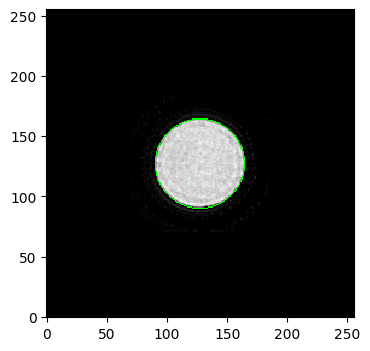

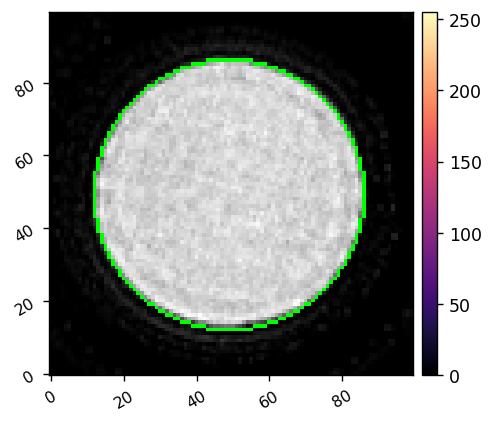

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte

# Load picture and detect edges
# image = img_as_ubyte(data.coins()[160:230, 70:270])
# image = img_as_ubyte(mask)
image = img_as_ubyte(np.abs(ref_amp)/np.max(np.abs(ref_amp)))
edges = canny(image, sigma=1, low_threshold=10, high_threshold=50)

# Detect two radii
hough_radii = np.arange(30, 50, 1)
hough_res = hough_circle(edges, hough_radii)

# Select the most prominent 3 circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

# Draw them
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
image = color.gray2rgb(image)
for center_y, center_x, radius in zip(cy, cx, radii):
    circy, circx = circle_perimeter(center_y, center_x, radius, shape=image.shape)
    image[circy, circx] = (0, 255, 0)

ax.imshow(image, cmap=plt.cm.gray)
plt.show()

imshow1(image, npix=100)

74


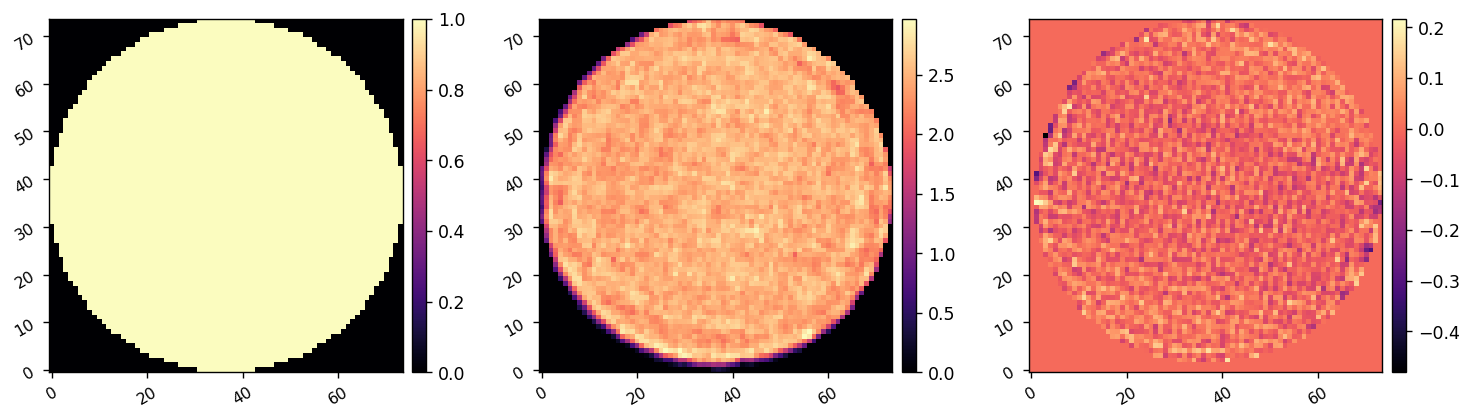

In [14]:
rad = radii[0]
amp = ref_amp[center_y-rad:center_y+rad, center_x-rad:center_x+rad]
phs = ref_phs[center_y-rad:center_y+rad, center_x-rad:center_x+rad]

npix_pr = amp.shape[0]
print(npix_pr)
y,x = (np.indices((npix_pr, npix_pr)) - npix_pr/2+1/2)
r = np.sqrt(x**2 + y**2)
fit_mask = r<(rad)
imshow3(fit_mask, amp*fit_mask, phs*fit_mask)

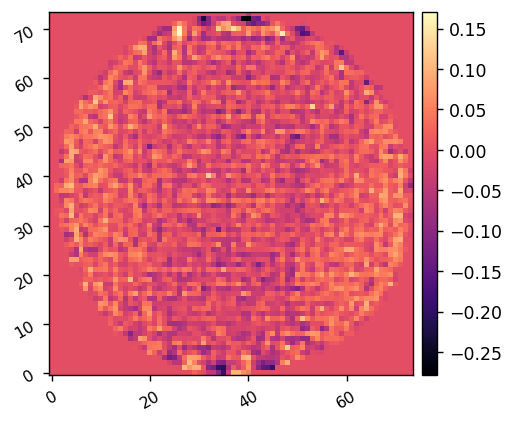

In [15]:
rotation = 74.5
# phs_corrected = xp.flipud(xp.array(phs))
phs_corrected = _scipy.ndimage.rotate(xp.array(phs), rotation, order=1, reshape=False)
imshow1(phs_corrected)

(1000, 1000)


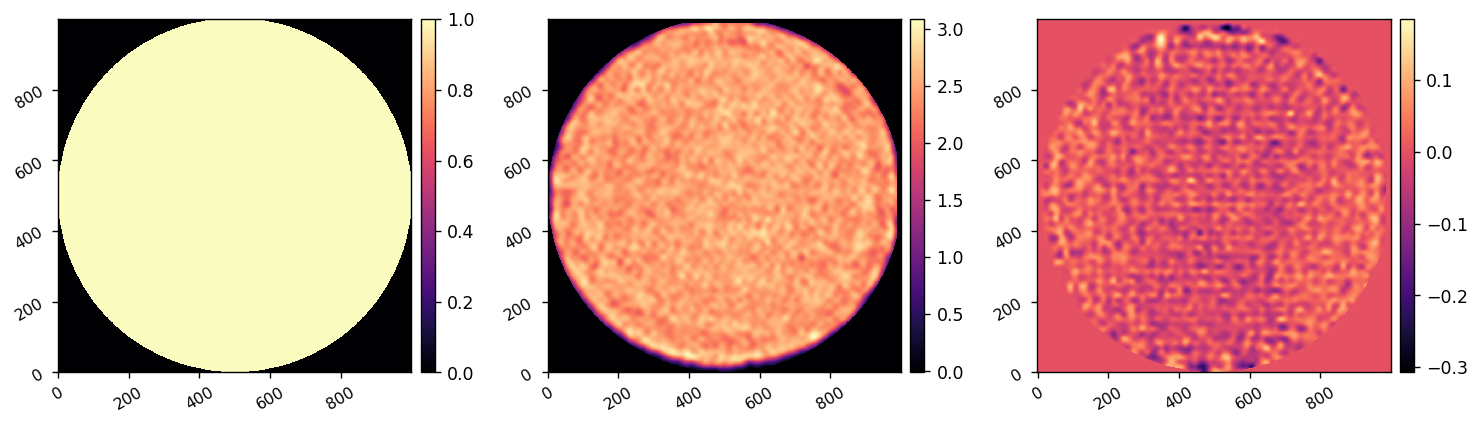

In [21]:
npix = 1000
y,x = (xp.indices((npix, npix)) - npix/2+1/2)
r = xp.sqrt(x**2 + y**2)
pup_mask = r<(npix/2)

amp_interpped = lina.utils.interp_arr(xp.array(amp), 1/npix_pr, 1/npix, order=4) * pup_mask
phs_interpped = lina.utils.interp_arr(xp.array(phs_corrected), 1/npix_pr, 1/npix, order=3) * pup_mask
print(amp_interpped.shape)

imshow3(pup_mask, amp_interpped, phs_interpped)

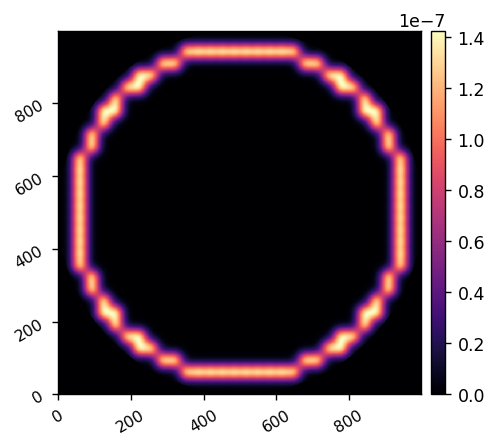

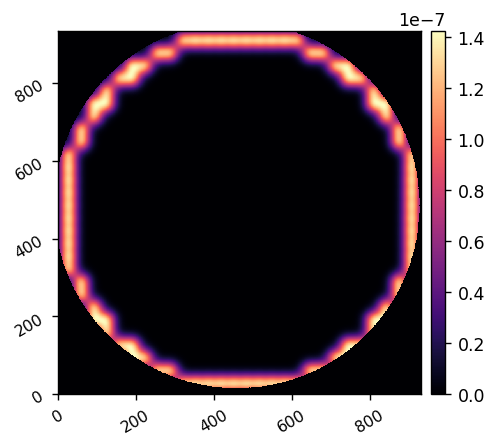

In [82]:
import adefc_vortex.scoob_model as scoobm
from importlib import reload
import astropy.units as u
reload(scoobm)
reload(utils)
M = scoobm.MODEL(
    # dm_beam_diam=9.2*u.mm, 
    # lyot_pupil_diam=9.2*u.mm,
    # dm_shift=np.array([0.1,0.0])*u.mm,
    lyot_shift=np.array([-0.075,0.15])*u.mm,
    # lyot_shift=np.array([-0.1,0.2])*u.mm,
)
# M.AMP = wfe_amp
# M.OPD = wfe_opd/10

# M.reverse_lyot = 1
# M.flip_lyot = 1
# M.det_rotation = 178

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

amp = 100e-9
command = xp.zeros((34,34))
command = amp*ring14

E_FP, E_EP, DM_PHASOR, E_DM, E_LP, E_LS = M.forward(
    command[M.dm_mask], 
    use_vortex=0, 
    return_ints=1,
)

E_EP = utils.pad_or_crop(E_EP, M.npix)
DM_PHASOR = utils.pad_or_crop(DM_PHASOR, M.npix)
E_DM = utils.pad_or_crop(E_DM, M.npix)
E_LS = utils.pad_or_crop(E_LS, 934)

imshow1(xp.angle(E_DM)*M.APERTURE)
imshow1(xp.angle(E_LS))

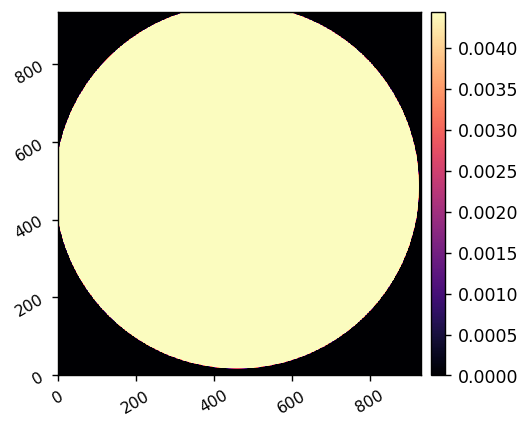

In [84]:
imshow1(xp.abs(E_LS))